In [1]:
import sys
print(sys.version)

import matplotlib.pyplot as plt
#%matplotlib inline
#%config BackendInline.figure_format='svg'

plt.style.use(['seaborn-paper', 'seaborn-white', 'seaborn-ticks'])
plt.matplotlib.rcParams['figure.dpi'] = 120
plt.matplotlib.rcParams['savefig.dpi'] = 120

import numpy as np
import pandas as pd

import mlgrad.model as model
import mlgrad.func as func
import mlgrad.func2 as regular
import mlgrad.loss as loss
import mlgrad.weights as weights
import mlgrad.averager as averager

from mlgrad import averager_it, averager_fg, fg, erm_fg, irgd, erm_irgd, erisk

3.11.2 (main, Mar 13 2023, 12:18:29) [GCC 12.2.0]


/tmp/ipykernel_104037/3675965635.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-paper', 'seaborn-white', 'seaborn-ticks'])
/tmp/ipykernel_104037/3675965635.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-paper', 'seaborn-white', 'seaborn-ticks'])
/tmp/ipykernel_104037/3675965635.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain availab

In [2]:
#plt.style.available

## Искусственный пример

In [3]:
def gendataset(N=70, a=3., b=9., q=0.4, dy=2.):
    M = int(q*N)
    X0 = np.linspace(-8., 8., N+1)
    Y0 = 2.+3.*X0
    Y0 += 2*dy*np.random.random(N+1)-dy
    if q > 0:
        X1 = a*np.random.random(M) - a - 8
        Y1 = b*(2*np.random.random(M)-1)
        Y1 += 2.+3.*X1 + 50
        X2 = a*np.random.random(M) - a + 9
        Y2 = b*(2*np.random.random(M)-1)
        Y2 += 2.+3.*X2 - 50
        X = np.hstack((X0, X1, X2))
        Y = np.hstack((Y0, Y1, Y2))
    else:
        X = X0
        Y = Y0
    Xs = X.reshape(-1,1)
    xrange = np.array(np.linspace(-8., 8., 10)).reshape(-1,1)
    return X, Y, Xs, xrange

In [4]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())
loss_func_hub = loss.ErrorLoss(func.Huber())
loss_func_tuk = loss.ErrorLoss(func.Tukey())
loss_func_lgs = loss.ErrorLoss(func.Logistic(1.0))
loss_func_quant = loss.ErrorLoss(func.Quantile(0.5))

In [5]:
def plot_log(d):
    plt.figure(figsize=(15,4))
    m = len(d)
    i = 1
    for key, vals in sorted(d.items()):
        plt.subplot(1, m, i)
        k_range, u_seq = zip(*enumerate(d[key]))
        plt.plot(k_range, u_seq, marker='s', markersize=3)
        plt.grid(1)
        plt.title(key)
        plt.minorticks_on()
        i += 1
        plt.tight_layout()
    plt.show()

In [6]:
def linear_regression_gd(Xs, Y, loss_func, h=0.01, tol=1.0e-6, n_iter=5000, callback=None):
    m = Xs.shape[1] + 1
    param_init = np.array(np.random.random(m))
    lm_line = model.LinearModel(param_init)
    er = erisk(Xs, Y, lm_line, loss_func)
    alg = erm_fg(er, h=h, tol=tol, n_iter=n_iter, verbose=1, callback=callback)
    return alg

In [7]:
def linear_regression_pb(X, Y, line_model, loss_func, penalty_func, callback=None, h=0.01, n_iter=100):
    avrfunc = averager_it(penalty_func, tol=1.0e-6, n_iter=5000)
    #avrfunc = averager_fg(penalty_func, h=0.01, tol=1.0e-5, n_iter=5000)
    #alg_reg = regular.Square()
    er = erisk(X, Y, line_model, loss_func)
    alg_fg = fg(er, h=h, tol=1.0e-6, n_iter=5000, stop_condition='diffL2')
    alg_weights = weights.MWeights(avrfunc, er)
    #irgd_averager = averager.ArrayCyclicAverager(20)
    irgd_averager = None
    alg_irgd = erm_irgd(alg_fg, alg_weights, tol=1.0e-4, callback=callback, param_averager=irgd_averager, n_iter=n_iter)
    return alg_irgd

In [8]:
def linear_m_regression(X, Y, line_model, loss_func, rho_func, callback=None):
    alg_reg = None # regular.Square()
    er = erisk(X, Y, line_model, loss_func)    
    alg_fg = fg(regular=alg_reg, h=0.01, tol=1.0e-6, n_iter=5000, tau=0.001)
    alg_weights = weights.RWeights(rho_func, er)
    #irgd_averager = averager.ArrayCyclicAverager(20)
    alg_irgd = erm_irgd(alg_fg, alg_weights, tol=1.0e-5, callback=callback, param_averager=None) #irgd_averager)
    return alg_irgd

In [9]:
q = 0.0
dy = 5
X0, Y0, X0s, xrange  = gendataset(q=q, dy=dy)

K=76 param=[2.03672464 3.09227851]


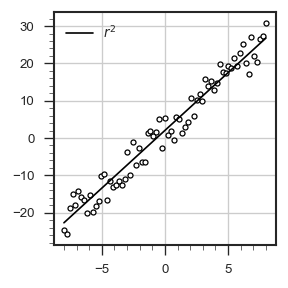

In [10]:
d0 = {"param":[], "lval":[]}
def callback0(alg, d=d0):
    d["lval"].append(alg.risk.lval)
    d["param"].append(alg.risk.param.base.copy())

alg_sq = linear_regression_gd(X0s, Y0, loss_func_sq, h=0.1, tol=1.0e-6, callback=callback0)
#w = alg_sq.model.param.base
#plot_log(d0)

plt.figure(figsize=(2.5, 2.5))
plt.scatter(X0, Y0, s=9, marker='o', c='w', edgecolors='k', linewidths=0.75) #, label='data')
plt.plot(xrange, alg_sq.risk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'$r^2$', linestyle='-')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig('fig/ni2017_linreg_1.eps')
plt.show()

In [11]:
q = 0.10
dy = 5
X1, Y1, X1s, xrange  = gendataset(q=q, dy=dy)

K=162 param=[1.84435482 0.82591206]
K=608 param=[2.37910615 2.75551447]
K=332 param=[2.3665684  2.70513766]


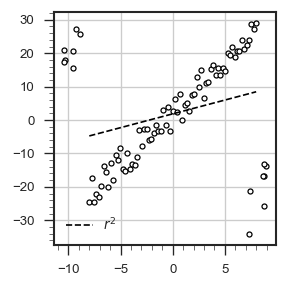

In [12]:
alg_sq = linear_regression_gd(X1s, Y1, loss_func_sq)
alg_abs = linear_regression_gd(X1s, Y1, loss_func_abs)
alg_hub = linear_regression_gd(X1s, Y1, loss_func_hub)

plt.figure(figsize=(2.5, 2.5))
plt.scatter(X1, Y1, s=9, marker='o', c='w', edgecolors='k', linewidths=0.75) #, label='data')
plt.plot(xrange, alg_sq.risk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'$r^2$', linestyle='--')
#plt.plot(xrange, alg_abs.model.evaluate_all(xrange), color='k', linewidth=1., label=r'$|r|$', linestyle='-.')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig('fig/ni2017_linreg_2.png')
plt.show()

In [13]:
def huber_func(r, c=1):
    xs = []
    for x in r:
        x_abs = abs(x)
        if x_abs <= c:
            v = (x_abs/c)**2
        else:
            v = 2.*(x_abs/c)-1.
        xs.append(v)
    return xs

def tukey_func(r, c=1):
    xs = []
    for x in r:
        x_abs = abs(x)
        if x_abs <= c:
            v = 1.-(1.-(x_abs/c)**2)**3
        else:
            v = 1.
        xs.append(v)
    return xs

def abs_trunc(r, c=1):
    xs = []
    for x in r:
        v = abs(x) - c
        if v < 0:
            v = 0.
        xs.append(v)
    return xs

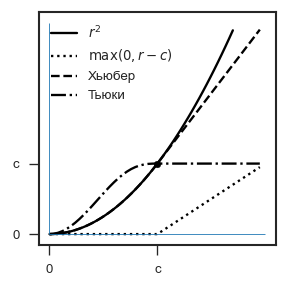

In [14]:
plt.figure(figsize=(2.5, 2.5))
range_x = np.linspace(0, 1.7, 50)
range_x2 = np.linspace(0, 1.95, 50)
plt.plot(range_x, np.power(range_x, 2), color='k', linestyle='-', label=r'$r^2$')
plt.plot(range_x2, abs_trunc(range_x2), color='k', linestyle=':', label=r'$\max(0,r-c)$')
plt.plot(range_x2, huber_func(range_x2), color='k', linestyle='--', label=r'Хьюбер')
plt.plot(range_x2, tukey_func(range_x2), color='k', linestyle='-.', label=r'Тьюки')
plt.scatter([1], [1], c='k', s=16)
plt.xticks([0, 1], [0, 'c'])
plt.yticks([0, 1], [0, 'c'])
plt.hlines(0, 0, 2.0, linewidth=0.5)
plt.vlines(0, 0, 3.0, linewidth=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('fig/ni2017_regr_3.png')
plt.show()

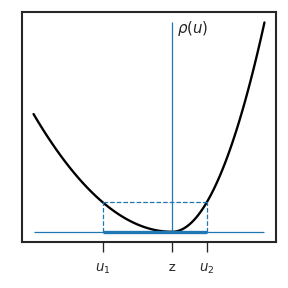

In [15]:
plt.figure(figsize=(2.5, 2.5))
range_x1 = np.linspace(-3., 0., 100)
range_x2 = np.linspace(0., 2., 100)
plt.plot(range_x1, 0.25*range_x1**2, color='k', linestyle='-')
plt.plot(range_x2, range_x2**2, color='k', linestyle='-')
plt.xticks([0, -1.5, 0.75], ['z','$u_1$','$u_2$'])
plt.vlines(0.75, 0., 0.75*0.75, linewidth=0.75, linestyle='--')
plt.vlines(-1.5, 0., 0.25*1.5*1.5, linewidth=0.75, linestyle='--')
plt.hlines(0, -3, 2, linewidth=0.75)
plt.hlines(0.75*0.75, -1.5, 0.75, linewidth=0.75, linestyle='--')
plt.hlines(0, -1.5, 0.75, linewidth=2.0)
plt.vlines(0, 0, 4, linewidth=0.75)
plt.yticks([], [])
plt.text(0.1, 3.8, r'$\rho(u)$', {'size':9})
plt.tight_layout()
plt.savefig('fig/ni2017_rho.png')
plt.show()

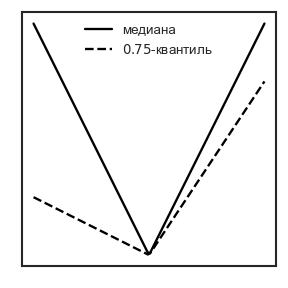

In [16]:
plt.figure(figsize=(2.5, 2.5))
range_x = np.linspace(-1., 1., 100)
range_x2 = np.linspace(-2., 2., 100)
plt.plot(range_x, np.abs(range_x), color='k', linestyle='-', label=r'медиана')
plt.plot(range_x, 0.25*np.abs(range_x)*(range_x<=0) + 0.75*np.abs(range_x)*(range_x>0), color='k', linestyle='--', label=r'$0.75$-квантиль')
#plt.plot(range_x, 0.75*np.abs(range_x)*(range_x<=0) + 0.25*np.abs(range_x)*(range_x>0), color='k', linestyle='-.', label=r'$0.25$-квантиль')
plt.legend(loc='best')
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.savefig('fig/ni2017_Mrho_robust.png')
plt.show()

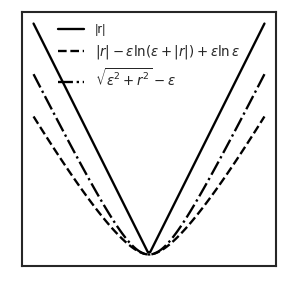

In [17]:
a=1.0
plt.figure(figsize=(2.5, 2.5))
range_x = np.linspace(-4., 4., 100)
range_x2 = np.linspace(-2., 2., 100)
plt.plot(range_x, np.abs(range_x), color='k', linestyle='-', label=r'|r|')
plt.plot(range_x, np.abs(range_x)-a*np.log(a+np.abs(range_x))+a*np.log(a), color='k', linestyle='--', label=r'$|r|-\varepsilon\ln(\varepsilon+|r|)+\varepsilon\ln\varepsilon$')
plt.plot(range_x, np.sqrt(a**2+range_x**2)-a, color='k', linestyle='-.', label=r'$\sqrt{\varepsilon^2+r^2}-\varepsilon$')
plt.legend(loc='best')
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.savefig('fig/ni2017_Mrho_robust2.png')
plt.show()

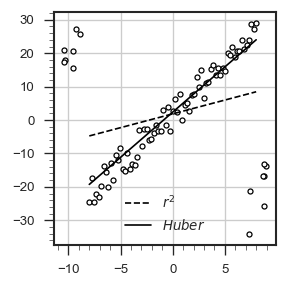

In [18]:
plt.figure(figsize=(2.5, 2.5))
plt.scatter(X1, Y1, s=9, marker='o', c='w', edgecolors='k', linewidths=0.75) #, label='data')
plt.plot(xrange, alg_sq.risk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'$r^2$', linestyle='--')
plt.plot(xrange, alg_hub.risk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'$Huber$', linestyle='-')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig('fig/ni2017_linreg_4.pdf')
plt.show()

In [19]:
q = 0.3
dy = 4
X2, Y2, X2s, xrange  = gendataset(q=q, dy=dy)
alpha = 0.01

In [20]:
alpha=0.01
#penalty_func_sq2 = func.Quantile_AlphaLog(alpha, 0.62)
penalty_func_sq2 = func.QuantileFunc(0.62, func.Sqrt(4.0))

d2 = {"u":[],"param":[], "K":[], "Ka":[], "lval":[], "pval":[], "s":[]}
def callback2(alg, d=d2):
    d["u"].append(alg.weights.average.u)
    # d["s"].append(alg.weights.average.s)
    d["K"].append(alg.gd.K)
    d["lval"].append(alg.gd.risk.lval)
    d["Ka"].append(alg.weights.average.K)
    d["pval"].append(alg.weights.average.pval)
    d["param"].append(alg.gd.risk.model.param.base.copy())

#param_init2 = np.random.random((2,))
param_init4 = np.array([0.,-1.])
lm_line4 = model.LinearModel(param_init4)

#alg_irgd2 = linear_regression_pb(X2s, Y2, lm_line4, loss_func_sq, penalty_func_sq2, callback=callback2, h=0.002, n_iter=100)

irgd2_avrfunc = averager_it(penalty_func_sq2, n_iter=5000)
er2 = erisk(X2s, Y2, lm_line4, loss_func_sq)    
irgd2_fg = fg(er2, h=0.005, tol=1.0e-7, n_iter=5000, stop_condition='diffL2')
irgd2_weights = weights.MWeights(irgd2_avrfunc, er2)
#irgd2_averager = averager.ArrayCyclicAverager(20)
alg_irgd2 = erm_irgd(irgd2_fg, irgd2_weights, callback=callback2, n_iter=30)

plot_log(d2)

NameError: name 'Average_Iterative' is not defined

In [ ]:
alg_sq = linear_regression_gd(X2s, Y2, loss_func_sq, h=0.01)
alg_abs = linear_regression_gd(X2s, Y2, loss_func_abs, h=0.2)
alg_hub = linear_regression_gd(X2s, Y2, loss_func_hub, h=0.1)
loss_func_tuk = loss.ErrorLoss(func.Tukey(40.))
alg_tuk = linear_regression_gd(X2s, Y2, loss_func_tuk, h=0.01)
#alg_quant = linear_regression_gd(X2s, Y2, loss.Loss(func.Quantile(0.5)))

plt.figure(figsize=(3.5,3.5))
plt.scatter(X2, Y2, s=9, marker='o', c='w', edgecolors='k', linewidths=0.75) #, label='data')
#plt.plot(xrange, alg_sq.model.evaluate_all(xrange), color='k', linewidth=1., label=r'$r^2$', linestyle='--')
plt.plot(xrange, alg_hub.risk.model.evaluate_all(xrange), color='k', linewidth=1., label='Huber', linestyle='--')
plt.plot(xrange, alg_tuk.risk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'Tukey', linestyle='-.')
#plt.plot(xrange, alg_quant.model.evaluate_all(xrange), color='k', linewidth=1., label=r'Quantile', linestyle='-.')
plt.plot(xrange, alg_irgd2.gd.risk.model.evaluate_all(xrange), color='k', linewidth=1., label='M/$r^2$', linestyle='-')
plt.grid(1)
plt.minorticks_on()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.savefig('fig/ni2017_pblinreg_30.pdf')
#plt.savefig('fig/ni2017_linreg_5.eps')
plt.show()

In [ ]:
q = 0.5
dy = 5
X25, Y25, X25s, xrange  = gendataset(q=q, dy=dy)
alpha = 0.01

In [ ]:
d25 = {"u":[],"param":[], "K":[], "Ka":[], "lval":[], "pval":[]}
def callback2(alg, d=d25):
    d["u"].append(alg.weights.average.u)
    d["K"].append(alg.gd.K)
    d["lval"].append(alg.gd.risk.lval)
    d["Ka"].append(alg.weights.average.K)
    d["pval"].append(alg.weights.average.pval)
    d["param"].append(alg.gd.risk.param.base.copy())

alpha=0.01
#penalty_func_sq2 = func.Quantile_AlphaLog(alpha, 0.50)
penalty_func_sq2 = func.Sqrt(4.0)

#param_init2 = np.random.random((2,))
param_init45 = np.array([0.,-1.])
lm_line45 = model.LinearModel(param_init45)

irgd25_avrfunc = averager_it(penalty_func_sq2, n_iter=5000)
er2 = erisk(X2s, Y2, lm_line4, loss_func_sq)    
irgd25_fg = fg(er2, h=0.005, tol=1.0e-7, n_iter=5000, stop_condition='diffL2')
irgd25_weights = weights.MWeights(irgd2_avrfunc, er2)
#irgd25_averager = averager.ArrayCyclicAverager(20)
alg_irgd25 = erm_irgd(irgd25_fg, irgd25_weights, param_averager=None, callback=callback2)

plot_log(d25)

In [ ]:
alg_sq = linear_regression_gd(X25s, Y25, loss_func_sq, h=0.2)
alg_abs = linear_regression_gd(X25s, Y25, loss_func_abs, h=0.2)
alg_hub = linear_regression_gd(X25s, Y25, loss_func_hub, h=0.1)
loss_func_tuk = loss.ErrorLoss(func.Tukey(30.))
alg_tuk = linear_regression_gd(X25s, Y25, loss_func_tuk, h=0.01)
#alg_quant = linear_regression_gd(X2s, Y2, loss.Loss(func.Quantile(0.5)))

plt.figure(figsize=(3.5,3.5))
plt.scatter(X25, Y25, s=9, marker='o', c='w', edgecolors='k', linewidths=0.75) #, label='data')
#plt.plot(xrange, alg_sq.model.evaluate_all(xrange), color='k', linewidth=1., label=r'$r^2$', linestyle='--')
plt.plot(xrange, alg_hub.risk.model.evaluate_all(xrange), color='k', linewidth=1., label='Huber', linestyle='--')
plt.plot(xrange, alg_tuk.risk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'Tukey', linestyle='-.')
#plt.plot(xrange, alg_quant.model.evaluate_all(xrange), color='k', linewidth=1., label=r'Quantile', linestyle='-.')
plt.plot(xrange, alg_irgd25.gd.risk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'M/$r^2$', linestyle='-')
plt.grid(1)
plt.minorticks_on()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.savefig('fig/ni2017_pblinreg_50.pdf')
#plt.savefig('fig/ni2017_linreg_6.eps')
plt.show()

In [ ]:
q = 0.60
dy = 3
X3, Y3, X3s, xrange  = gendataset(q=q, dy=dy)

In [ ]:
penalty_func = func.Quantile_AlphaLog(0.1, 0.4)
penalty_func

In [ ]:
alg_s = linear_regression_gd(X3s, Y3, loss_func_sq, h=0.5)
alg_a = linear_regression_gd(X3s, Y3, loss_func_abs)
loss_func_hub = loss.ErrorLoss(func.Huber(40.))
alg_h = linear_regression_gd(X3s, Y3, loss_func_hub)
loss_func_tuk = loss.ErrorLoss(func.Tukey(40.))
alg_t = linear_regression_gd(X3s, Y3, loss_func_tuk)
alg_l = linear_regression_gd(X3s, Y3, loss_func_lgs, h=0.05)
alg_q = linear_regression_gd(X3s, Y3, loss.ErrorLoss(func.Quantile(0.51)))

In [ ]:

d = {"u":[],"param":[], "K":[], "Ka":[], "lval":[], "pval":[]}
def callback(alg, d=d):
    d["u"].append(alg.weights.average.u)
    d["K"].append(alg.gd.K)
    d["lval"].append(alg.gd.risk.lval)
    d["Ka"].append(alg.weights.average.K)
    d["pval"].append(alg.weights.average.pval)
    d["param"].append(alg.gd.risk.param.base.copy())


In [ ]:
alpha=0.01
#loss_func_sq = loss.Loss(func.Square())
penalty_func_sq = func.Quantile_AlphaLog(alpha, 0.6)
#penalty_func_sq2 = func.QuantileFunc(0.45, func.Sqrt(alpha))

param_init2 = np.random.random((2,))
#param_init2 = np.array([2.,3.])
lm_line2 = model.LinearModel(param_init2)

alg_irgd = linear_regression_pb(X3s, Y3, lm_line2, loss_func_sq, penalty_func_sq2, callback=callback, h=0.01, n_iter=100)

plot_log(d)

In [ ]:
#plt.figure(figsize=(3.5, 3))
plt.figure(figsize=(2.5, 2.5))
#plt.title(r'шум: %s, выбросы: %s%%' % (dy, int(200*q)))
plt.scatter(X3, Y3, s=9, marker='o', c='w', edgecolors='k', linewidths=0.75)
plt.grid(1)
plt.minorticks_on()
#plt.plot(xrange, lm_line2.evaluate_all(xrange), color='k', linewidth=1., label=r'LQS$_\alpha$ (0.5)')
#plt.plot(xrange, lm_line3.evaluate_all(xrange), color='k', linewidth=1.0, label=r'M${\sqrt{1+r^2}}-1:|r|$')
#plt.plot(xrange, alg_s.model.evaluate_all(xrange), color='k', linewidth=1., linestyle='--', label=r'$r^2$')
#plt.plot(xrange, alg_a.model.evaluate_all(xrange), color='k', linewidth=1., linestyle='-.', label=r'$|r|$')
plt.plot(xrange, alg_h.risk.model.evaluate_all(xrange), color='k', linewidth=1., linestyle='--', label='Huber')
plt.plot(xrange, alg_t.risk.model.evaluate_all(xrange), color='k', linewidth=1., linestyle='-.', label='Tukey')
#plt.plot(xrange, alg_l.model.evaluate_all(xrange), color='k', linewidth=1., linestyle='-', marker='s', label='Logistic')
#plt.plot(xrange, alg_q.model.evaluate_all(xrange), color='k', linewidth=1., linestyle='-.', label=r'LQ$_\alpha$ 0.51')
plt.plot(xrange, alg_irgd.gd.risk.model.evaluate_all(xrange), color='k', linewidth=1., label='M/$r^2$', linestyle='-')
#plt.xlim(-5, 20)
plt.legend(loc='best')
#plt.xticks([],[])
#plt.yticks([],[])
plt.tight_layout()
plt.savefig('fig/ni2017_pblinreg_3.pdf')
plt.show()

## Diabets

In [ ]:
# df = pd.read_csv('data/diabets.txt', sep='\t')

# AGE = df['AGE'].values
# SEX = df['SEX'].values
# BMI = df['BMI'].values
# BP = df['BP'].values
# S1 = df['S1'].values
# S2 = df['S2'].values
# S3 = df['S3'].values
# S4 = df['S4'].values
# S5 = df['S5'].values
# S6 = df['S6'].values

# diabet_Y = df['Y'].values
# diabet_Y = diabet_Y.astype('d')
# diabet_X = np.c_[AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6]

# print(diabet_X.shape, diabet_X.dtype, diabet_Y.dtype)

In [ ]:
# diabet_pca = decomposition.PCA()
# diabet_pca.fit(diabet_X)

# plt.figure(figsize=(5,3))
# plt.bar(range(diabet_X.shape[-1]), diabet_pca.explained_variance_ratio_)
# plt.show()

In [ ]:
# diabet_pca.n_components = 2
# U = diabet_pca.fit_transform(diabet_X)

In [ ]:
# plt.scatter(U[:,0], U[:,1], c=diabet_Y)
# plt.show()

In [ ]:
# skl_lr = linear_model.HuberRegressor()
# skl_lr.fit(U, diabet_Y)
# print(skl_lr.coef_, skl_lr.intercept_)

In [ ]:
# err = np.abs(diabet_Y - skl_lr.predict(U))
# err.sort()

In [ ]:
#lms_lr_model = model.LinearModel(np.random.random(size=2))
#lms_lr = pbsa.PbFG(lms_lr_model, loss.Absolute(), dissimilarity.Median_AlphaLog(0.001), hw=10.0, hu=10.0, tol=1.0e-4, max_epoch=100)
#lms_lr.fit(U, diabet_Y)
#print(lms_lr.K, lms_lr.u, lms_lr_model.param.base)

In [ ]:
#err2 = np.abs(diabet_Y - lms_lr_model.evaluate_all(diabet_X))
#err2.sort()

In [ ]:
# plt.figure(figsize=(6,3))
# plt.plot(range(err2.shape[0]), err2, label='lms')
# plt.plot(range(err.shape[0]), err, label='huber')
# plt.legend(loc='best')
# plt.show()